In [1]:
import random
import time
import pandas as pd
from pathlib import Path
from processing.corpus import Corpus

DATA_PATH = Path('data\\raw\\labels.parquet')
SAVE_PATH = Path('data\\dataset.parquet')
SEED = random.seed(0)
DOWNSAMPLE = False

config = {
    'generate_embeddings': False,
    'load_embeddings': True,
    'load_CoNNL': True,
    'load_sentiments': True,
    'for_model': 'CRF', # 'Tree'
}

# Load Corpus

In [2]:
dataset = pd.read_parquet(DATA_PATH)['Word']
doc_ids = dataset.index.get_level_values('doc')

if DOWNSAMPLE:
    n_docs = 25
    sample_ids = random.sample(set(doc_ids), n_docs)
    data_ds = dataset[doc_ids.isin(sample_ids)].copy()

    dataset = data_ds
    
corpus = Corpus(dataset)

Indexing sentences for 4993 documents.


# Annotation

Add more general features using functionalities built into `Corpus`.

In [3]:
# add index position information and stemmed token 
corpus.process(*['add_locators', 'add_stem'])

# add binary markers for a variety of token attributes
corpus.process('mark_')
print(corpus.df.columns)

Added columns ['add_locators', 'add_stem']
                         token  sent_id  sent_loc      stem  is_upper  \
doc      sent word                                                      
10036953 1    1              [        1         1         [     False   
              2         Triple        1         2     tripl     False   
              3        therapy        1         3   therapi     False   
              4       regimens        1         4   regimen     False   
              5      involving        1         5    involv     False   
...                        ...      ...       ...       ...       ...   
9989713  15   21    randomised       15        21  randomis     False   
              22             ,       15        22         ,     False   
              23      clinical       15        23    clinic     False   
              24        trials       15        24     trial     False   
              25             .       15        25         .     False   

       

Generate `fasttext` embeddings for the data. This step is very memory-intensive, skip this if you don't have a fast enough system to run it. Once created, the function can load the data from a specified filepath.

Loading FastText embeddings from data\features\ft_embeds.parquet.
138 remaining after PCA analysis.


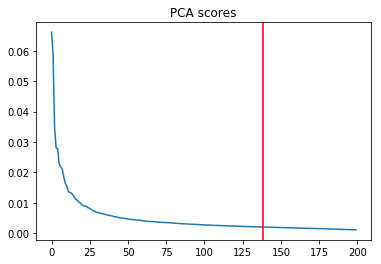

In [4]:
if config['generate_embeddings']: 
    corpus.load_embeddings(model_path='models/ft_models/BioWordVec_PubMed_MIMICIII_d200.bin')
elif config['load_embeddings']:
    corpus.load_embeddings(file_path='data\\features\\ft_embeds.parquet')

Generate or load the CoNLL data parsed by `stanfordnlp`.

In [5]:
if config['load_CoNNL']: 
    corpus.load_CoNLL(file_path='data\\features\\conll.parquet')
    parental_features = ['par_' + col for col in ['token', 'lemma', 'deprel', 'upos', 'xpos']]
    corpus.parse_deprel(parental_features)

Loading CoNLL data from data\features\conll.parquet.


In [6]:
x = pd.read_csv('data\\features\\conll.csv', sep='\t', header=None, keep_default_na=False, na_values=None)
x.index = corpus.df.index

Run a sentiment analysis over the sentences using TextBlob and add the polarity and subjectivity of each token's sentence as a feature.

In [7]:
if config['load_sentiments']: corpus.load_sentiments()

Running TextBlob sentiment analysis over 1354239 instances.


Generate a column for TF-IDF from the lookup table generated during initialization.

In [8]:
corpus.add_tfidf()

assert 'xpos' in corpus.df.columns
corpus.add_pos_stem() # add a stemmed version of the CoNNL XPOS (basic grammar info, i.e. NN, VB)

Perform some cleaning on the columns and produce some lagged columns that give information about a word's neighbours. Missing values are imputed by various procedures, and shifts are performed on a document level.

In [9]:
# lags
window = 2
lag_features = ['is_int', 'is_dec', 'first_word', 'last_word', 'form', 'lemma', 'upos', 'xpos', 'deprel', 'tfidf']
par_cols = corpus.df.columns[corpus.df.columns.str.startswith('par')]
fill_tag = '_' # fill missing strings with a custom value

corpus.lag_cols(['is_int', 'is_dec', 'first_word', 'last_word'], window, level='doc', fill_value=False)
corpus.lag_cols(['token', 'lemma', 'upos', 'xpos', 'deprel'], window, level='doc', fill_value=fill_tag)
corpus.lag_cols(['tfidf'], window, level='doc', fill_value=0.0)

# Save

We can save the data to various formats directly through `Corpus`. The exported feature table includes the labels in the index (`df.reset_index()['token']`)

In [10]:
print('features in the final set: \n', list(corpus.df.columns))
assert corpus.df.columns.isna().sum().sum() == 0

features in the final set: 
 ['token', 'sent_id', 'sent_loc', 'stem', 'is_upper', 'is_lower', 'is_title', 'near_cap', 'first_sent', 'last_sent', 'first_word', 'last_word', 'is_int', 'is_dec', 'punctuation', 'stopword', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22', 'PCA_23', 'PCA_24', 'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_29', 'PCA_30', 'PCA_31', 'PCA_32', 'PCA_33', 'PCA_34', 'PCA_35', 'PCA_36', 'PCA_37', 'PCA_38', 'PCA_39', 'PCA_40', 'PCA_41', 'PCA_42', 'PCA_43', 'PCA_44', 'PCA_45', 'PCA_46', 'PCA_47', 'PCA_48', 'PCA_49', 'PCA_50', 'PCA_51', 'PCA_52', 'PCA_53', 'PCA_54', 'PCA_55', 'PCA_56', 'PCA_57', 'PCA_58', 'PCA_59', 'PCA_60', 'PCA_61', 'PCA_62', 'PCA_63', 'PCA_64', 'PCA_65', 'PCA_66', 'PCA_67', 'PCA_68', 'PCA_69', 'PCA_70', 'PCA_71', 'PCA_72', 'PCA_73', 'PCA_74', 'PCA_75', 'PCA_76', 'PCA_77', 'PCA_78', '

In [13]:
corpus.save(f'data\\another.parquet')